In [1]:
try:
    import torchvision
except ImportError:
    !mamba install torchvision
try:
    import fastbook
except ImportError:
    !pip install -Uqq fastbook

In [2]:
fastbook.setup_book()

In [3]:
from fastai.vision.all import *
from fastbook import *
from torchvision import datasets, transforms

In [4]:
matplotlib.rc('image', cmap='Greys')

In [5]:
data_path = Path('data')
data_path.mkdir(exist_ok=True)

In [6]:
transform = transforms.ToTensor()

In [7]:
train_dataset = datasets.MNIST(
    root=data_path,
    train=True,
    download=True,
    transform=transform
)
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
valid_dataset = datasets.MNIST(
    root=data_path,
    train=False,
    download=True,
    transform=transform
)
valid_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [9]:
def filter_2s_and_7s(dataset):
    indices = [i for i, (img, label) in enumerate(dataset) if label in [2, 7]]
    return torch.utils.data.Subset(dataset, indices)

In [10]:
train_2s_and_7s = filter_2s_and_7s(train_dataset)
valid_2s_and_7s = filter_2s_and_7s(valid_dataset)

In [11]:
len(train_2s_and_7s)

12223

In [12]:
import matplotlib.pyplot as plt

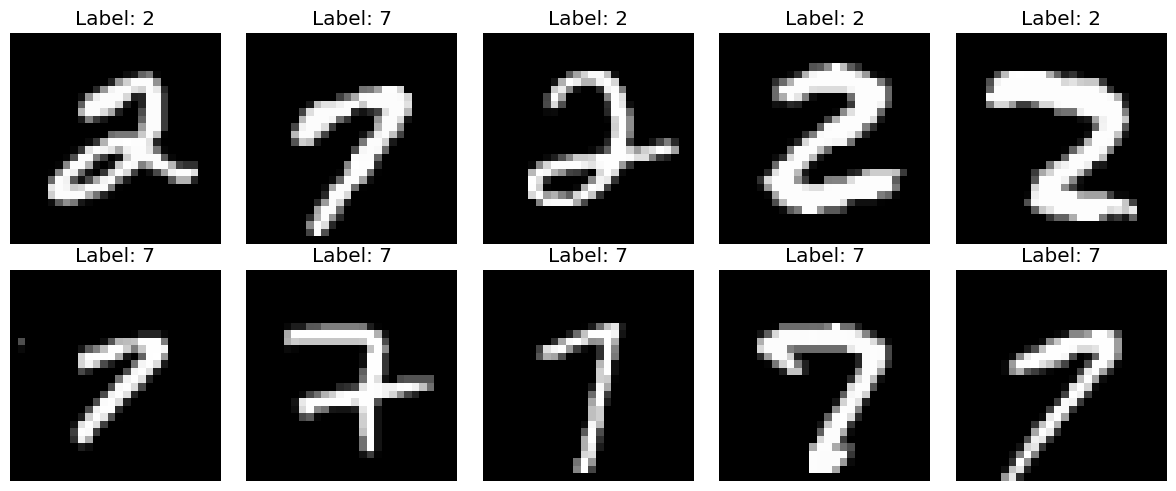

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img, label = train_2s_and_7s[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [14]:
train_2s = [img for img, label in train_2s_and_7s if label == 2]
train_7s = [img for img, label in train_2s_and_7s if label == 7]

In [15]:
valid_2s = torch.stack([img for img, label in valid_2s_and_7s if label == 2])
valid_7s = torch.stack([img for img, label in valid_2s_and_7s if label == 7])

In [16]:
stacked_2s = torch.stack(train_2s)
stacked_7s = torch.stack(train_7s)

In [17]:
mean_2 = stacked_2s.mean(dim=0)
mean_7 = stacked_7s.mean(dim=0)

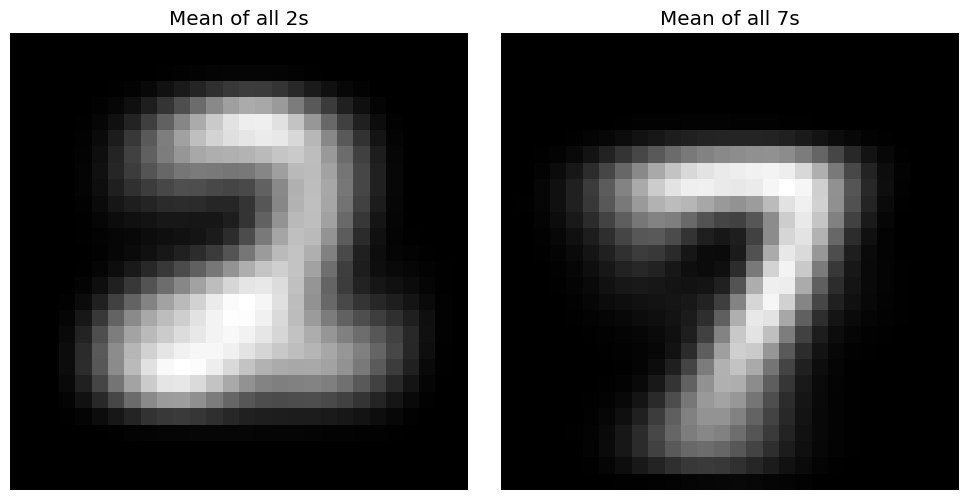

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Average of all 2s
axes[0].imshow(mean_2.squeeze(), cmap='gray')
axes[0].set_title('Mean of all 2s')
axes[0].axis('off')

# Average of all 7s
axes[1].imshow(mean_7.squeeze(), cmap='gray')
axes[1].set_title('Mean of all 7s')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [19]:
a_2 = stacked_2s[1]

The difference between a 2 and the ideal 2 is less than the distance between a 2 and an ideal 7 - this is good!

In [20]:
F.l1_loss(a_2.float(),mean_2), F.mse_loss(a_2,mean_2).sqrt()

(tensor(0.1317), tensor(0.2273))

In [21]:
F.l1_loss(a_2.float(),mean_7), F.mse_loss(a_2,mean_7).sqrt()

(tensor(0.1401), tensor(0.2683))

In [22]:
def mnist_distance(a, b): return (a - b).abs().mean((-1, -2))

In [23]:
mnist_distance(a_2, mean_2)

tensor([0.1317])

In [24]:
def is_2(x): return mnist_distance(x, mean_2) < mnist_distance(x, mean_7)

In [25]:
is_2(valid_2s)

tensor([[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [False],
        [ True]])

In [26]:
is_2(valid_2s).float().mean(), (1 - is_2(valid_2s).float()).mean()

(tensor(0.8740), tensor(0.1260))

In [27]:
train_x = torch.cat([stacked_2s, stacked_7s]).view(-1, 28 * 28)
train_y = tensor([1] * len(train_2s) + [0] * len(train_7s)).unsqueeze(1)

In [28]:
train_x.shape,train_y.shape

(torch.Size([12223, 784]), torch.Size([12223, 1]))

In [29]:
dset = list(zip(train_x, train_y))
x, y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [30]:
valid_x = torch.cat([valid_2s, valid_7s]).view(-1, 28 * 28)
valid_y = tensor([1] * len(valid_2s) + [0] * len(valid_7s)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

In [31]:
def init_params(size, std = 1.0): return (torch.randn(size) * std).requires_grad_()

In [32]:
weights = init_params((28 * 28, 1))

In [33]:
bias = init_params(1)

In [34]:
(train_x[0] * weights.T).sum() + bias

tensor([-15.4181], grad_fn=<AddBackward0>)

In [35]:
def linear1(xb): return xb@weights + bias

In [36]:
preds = linear1(train_x)
preds

tensor([[-15.4181],
        [-12.4617],
        [-22.2209],
        ...,
        [ -9.5576],
        [-18.0690],
        [  8.8109]], grad_fn=<AddBackward0>)

In [37]:
corrects = (preds > 0.0).float() == train_y
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [False]])

In [38]:
corrects.float().mean().item()

0.5323570370674133

In [39]:
with torch.no_grad(): weights[0] *= 1.0001

In [40]:
preds = linear1(train_x)
((preds > 0.0).float() == train_y).float().mean().item()

0.5323570370674133

In [41]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets == 1, 1 - predictions, predictions).mean()

In [42]:
dl = DataLoader(dset, batch_size = 256)
xb, xy = first(dl)
xb.shape, xy.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [43]:
valid_dl = DataLoader(valid_dset, batch_size = 256)

Extract first 4 elements

In [44]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [45]:
preds = linear1(batch)
preds

tensor([[-15.4181],
        [-12.4617],
        [-22.2209],
        [ -5.5130]], grad_fn=<AddBackward0>)

In [46]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.9990, grad_fn=<MeanBackward0>)

In [47]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0002), tensor([-0.0010]))

Put into function

In [48]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [49]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0004), tensor([-0.0020]))

In [50]:
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

In [51]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad * lr
            p.grad.zero_()

In [52]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb
    return correct.float().mean()

In [53]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.)

In [54]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [55]:
validate_epoch(linear1)

0.576

In [56]:
lr = 1.
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.7561

In [57]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end = ' ')

0.8772 0.9171 0.9366 0.9449 0.954 0.9575 0.9596 0.9622 0.964 0.967 0.9674 0.9674 0.9705 0.9709 0.9714 0.9709 0.9722 0.9722 0.9718 0.9727 